In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import shutil

In [12]:
base_dir = '/content/drive/MyDrive/brain_MRI_dataset/brain_mri_scan_images'

In [13]:
positive_dir = os.path.join(base_dir, "positive")
negative_dir = os.path.join(base_dir, "negative")

In [14]:
output_dir = "Dataset"
classes = ["positive", "negative"]
splits = ["train", "val", "test"]

In [15]:
for split in splits:
  for cls in classes:
    os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [16]:
from sklearn.model_selection import train_test_split

In [18]:
def split_and_copy(image_dir, class_name):
    images = os.listdir(image_dir)

    train_images, test_images = train_test_split(images, test_size=0.20, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.50, random_state=42)

    # Copy to train
    for img in train_images:
        shutil.copy(os.path.join(image_dir, img),
                    os.path.join(output_dir, "train", class_name, img))

    # Copy to val
    for img in val_images:
        shutil.copy(os.path.join(image_dir, img),
                    os.path.join(output_dir, "val", class_name, img))

    # Copy to test
    for img in test_images:
        shutil.copy(os.path.join(image_dir, img),
                    os.path.join(output_dir, "test", class_name, img))

    print(f"{class_name}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

split_and_copy(positive_dir, "positive")
split_and_copy(negative_dir, "negative")

positive: Train=103, Val=13, Test=13
negative: Train=78, Val=10, Test=10


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    "Dataset/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary"
)

val_data = val_test_datagen.flow_from_directory(
    "Dataset/val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary"
)

test_data = val_test_datagen.flow_from_directory(
    "Dataset/test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 181 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [22]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')   # Binary classification
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.5639 - loss: 0.6563 - val_accuracy: 0.7391 - val_loss: 0.5666
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.6688 - loss: 0.6273 - val_accuracy: 0.7391 - val_loss: 0.5322
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7402 - loss: 0.5896 - val_accuracy: 0.7826 - val_loss: 0.5179
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6933 - loss: 0.5657 - val_accuracy: 0.7391 - val_loss: 0.5151
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6717 - loss: 0.5965 - val_accuracy: 0.7391 - val_loss: 0.5225
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7043 - loss: 0.5581 - val_accuracy: 0.7391 - val_loss: 0.5163
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7630 - loss: 0.5101 - val_accuracy: 0.7826 - val_loss: 0.5236
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7767 - loss: 0.5322 - val_accuracy: 0.7391 - val_loss: 0.5246
Epoch 9/

In [24]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7826 - loss: 0.5468
Test Accuracy: 0.782608687877655


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


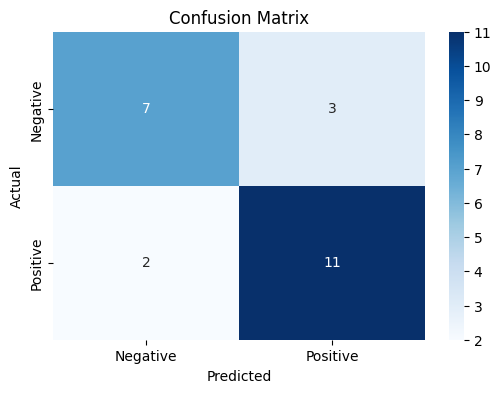

              precision    recall  f1-score   support

    Negative       0.78      0.70      0.74        10
    Positive       0.79      0.85      0.81        13

    accuracy                           0.78        23
   macro avg       0.78      0.77      0.78        23
weighted avg       0.78      0.78      0.78        23



In [26]:
y_pred = (model.predict(test_data) > 0.5).astype("int32")
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

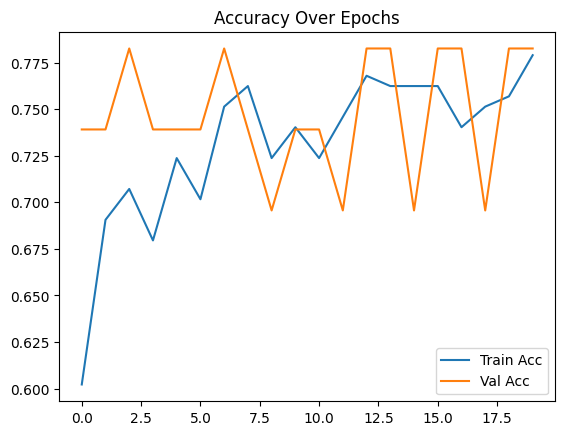

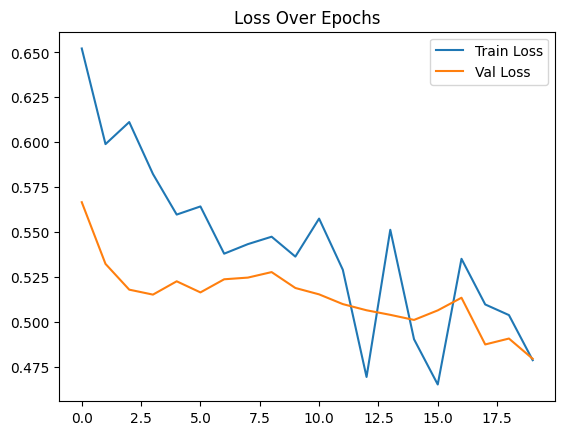

In [27]:
# Accuracy graph
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")
plt.show()

# Loss graph
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

In [28]:
import random
from tensorflow.keras.preprocessing import image
from PIL import Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


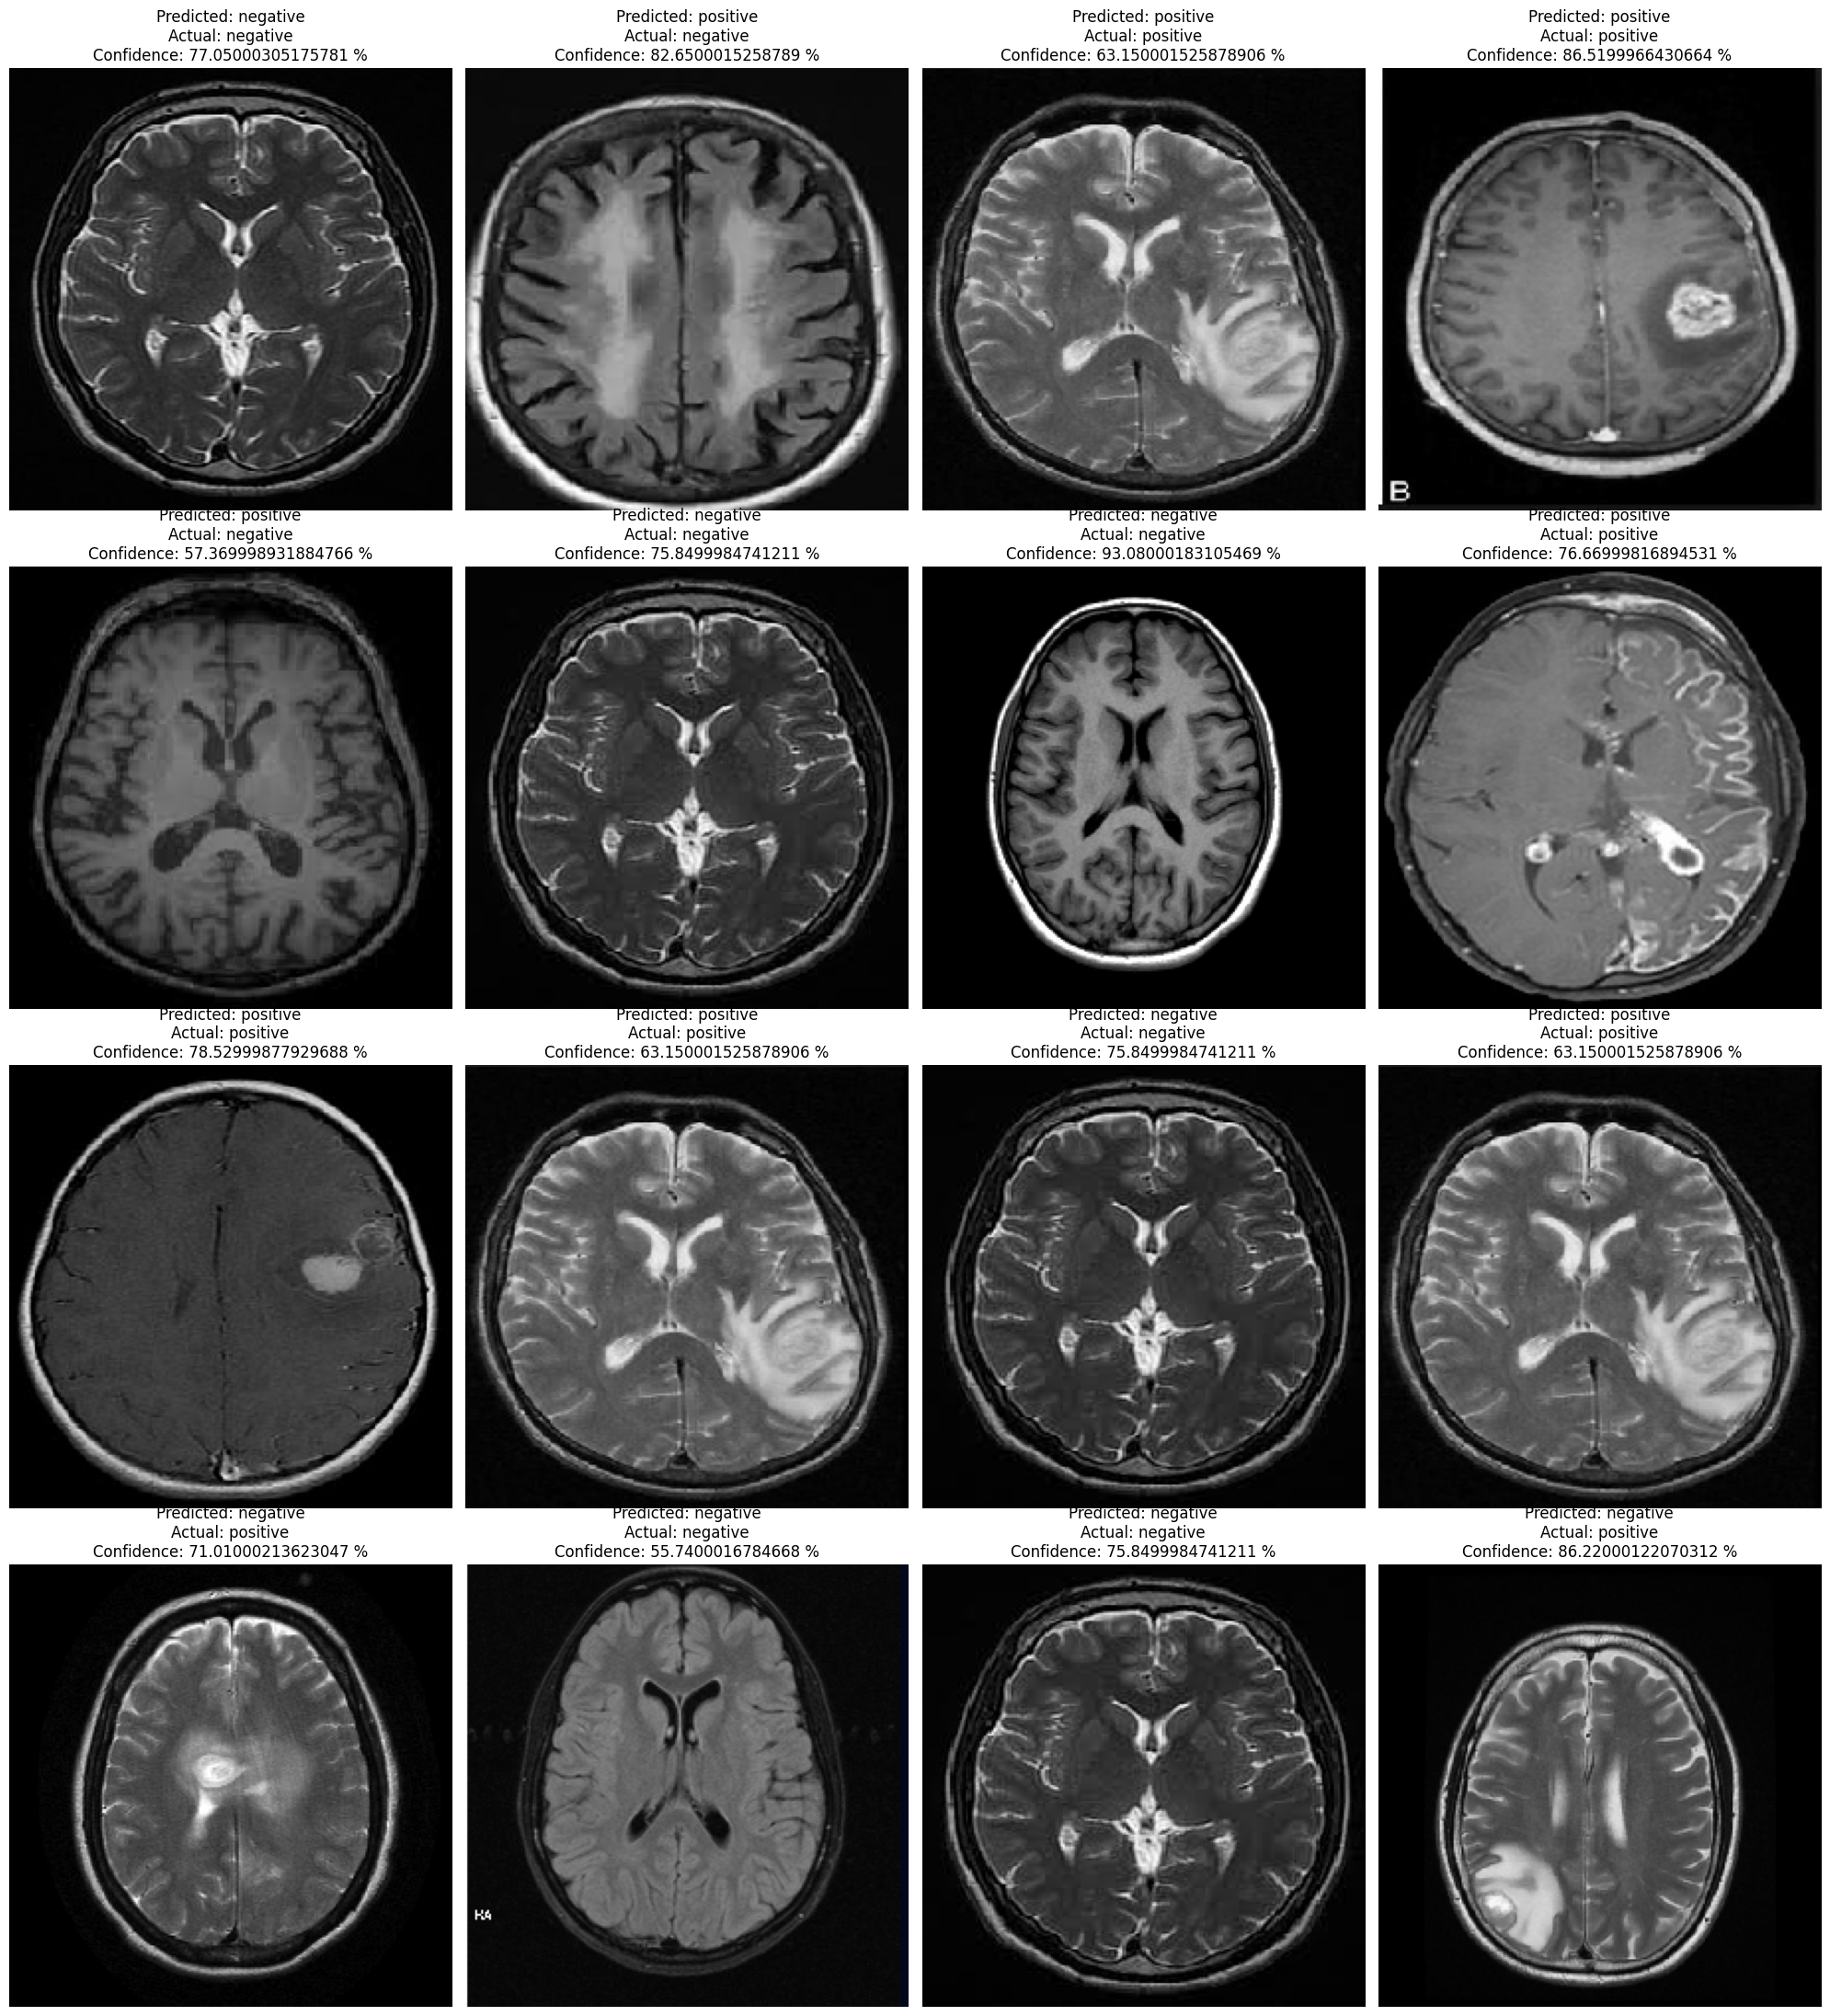

In [29]:
test_dir = "Dataset/test"
classes = ["positive", "negative"]

fig, axes = plt.subplots(4, 4, figsize=(20, 22))
axes = axes.ravel()

for i in range(16):

    # Randomly choose class folder
    actual_class = random.choice(classes)
    class_path = os.path.join(test_dir, actual_class)

    # Randomly choose image file
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    # Load the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)[0][0]

    predicted_class = "positive" if pred > 0.5 else "negative"
    confidence = round(pred*100, 2) if pred > 0.5 else round((1-pred)*100, 2)

    # Display image with labels
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(
        f"Predicted: {predicted_class}\n"
        f"Actual: {actual_class}\n"
        f"Confidence: {confidence} %"
    )

plt.tight_layout()
plt.show()

In [30]:
img_path = "/content/drive/MyDrive/brain_MRI_dataset/brain_mri_scan_images/negative/35.jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
print("Raw Prediction:", prediction)

# Interpret
if prediction[0] > 0.5:
    print("Tumor Detected")
else:
    print("No Tumor Detected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Raw Prediction: [[0.24154226]]
No Tumor Detected


In [31]:
img_path = "/content/drive/MyDrive/brain_MRI_dataset/brain_mri_scan_images/positive/105.jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
print("Raw Prediction:", prediction)

# Interpret
if prediction[0] > 0.5:
    print("Tumor Detected")
else:
    print("No Tumor Detected")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Raw Prediction: [[0.54349834]]
Tumor Detected
